### Импорт необходимых библиотек

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

### Загрузка данных

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

### Изменение размера изображений и масок

In [3]:
def resize(input_image, input_mask):
    return tf.image.resize(input_image, (128, 128)), tf.image.resize(input_mask, (128, 128))

### Аугментация данных

In [4]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask


### Нормализация значений пикселей изображений и масок

In [5]:
def normalize(input_image, input_mask):
    return tf.cast(input_image, tf.float32) / 255.0, input_mask - 1

### Функции для загрузки изображений

In [6]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask
   
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

### Создание наборов данных:

In [7]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

### Настройка батчей для обработки данных

In [8]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

### Функция визуализации изображений и масок

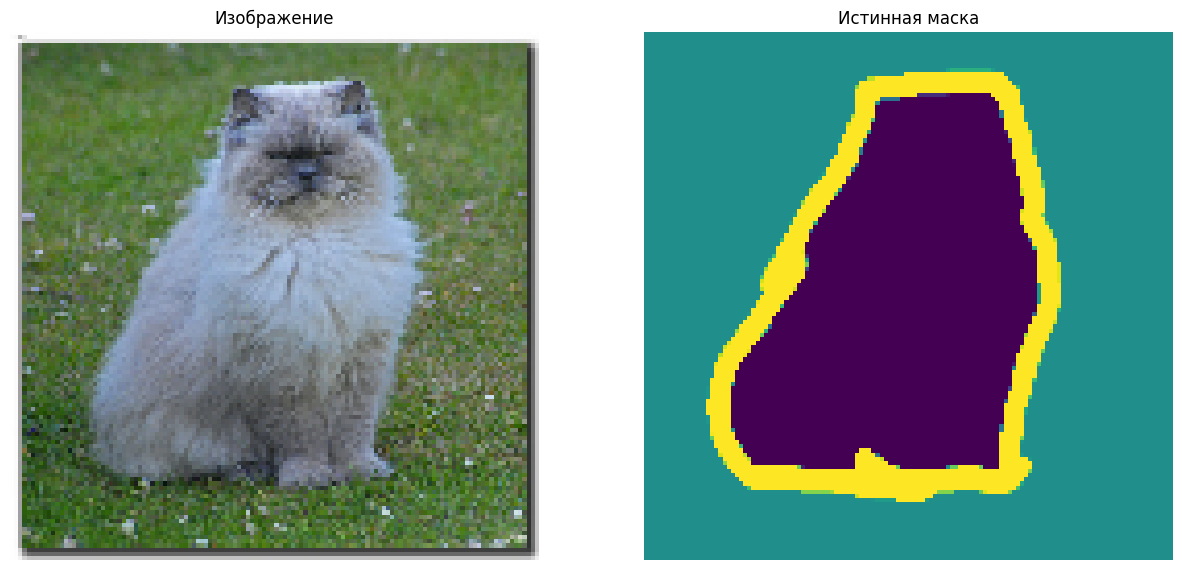

In [9]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Изображение", "Истинная маска", "Предсказанная маска"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

Определение модели автоэнкодера

In [10]:
def build_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D(2)(x)

    # Decoder
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)

    # Output: 3 classes with softmax
    outputs = layers.Conv2D(3, 1, activation='softmax', padding='same')(x)

    return keras.Model(inputs, outputs)

### Создание и компиляция модели автоэнкодера

In [11]:
# Создание и компиляция модели
input_shape = (128, 128, 3)
autoencoder_model = build_autoencoder(input_shape)
autoencoder_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




### Настройка параметров обучения

In [12]:
NUM_EPOCHS = 20
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENGTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS


### Обучение модели автоэнкодера

In [13]:
# Обучение модели
model_history = autoencoder_model.fit(
    train_batches,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 310ms/step - accuracy: 0.5917 - loss: 0.8844 - val_accuracy: 0.6969 - val_loss: 0.7157
Epoch 2/20


c:\Новая папка\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 299ms/step - accuracy: 0.6960 - loss: 0.7012 - val_accuracy: 0.7435 - val_loss: 0.6017
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 35s 305ms/step - accuracy: 0.7246 - loss: 0.6359 - val_accuracy: 0.7527 - val_loss: 0.5829
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 36s 310ms/step - accuracy: 0.7583 - loss: 0.5698 - val_accuracy: 0.7801 - val_loss: 0.5256
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 296ms/step - accuracy: 0.7679 - loss: 0.5464 - val_accuracy: 0.7943 - val_loss: 0.4937
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 296ms/step - accuracy: 0.7848 - loss: 0.5112 - val_accuracy: 0.7955 - val_loss: 0.4915
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 296ms/step - accuracy: 0.7904 - loss: 0.5000 - val_accuracy: 0.8031 - val_loss: 0.4755
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 296ms/step - accuracy: 0.7998 - loss: 0.4775 - val_accuracy: 0.8073 - val_loss: 0.4679
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 295ms/step - accuracy: 0.7994 - loss: 0.4781 - val

### Функции для создания маски и отображение предсказаний

In [14]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
def show_predictions(dataset=None, num=1):
  if dataset:
   for image, mask in dataset.take(num):
     pred_mask = autoencoder_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 21


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


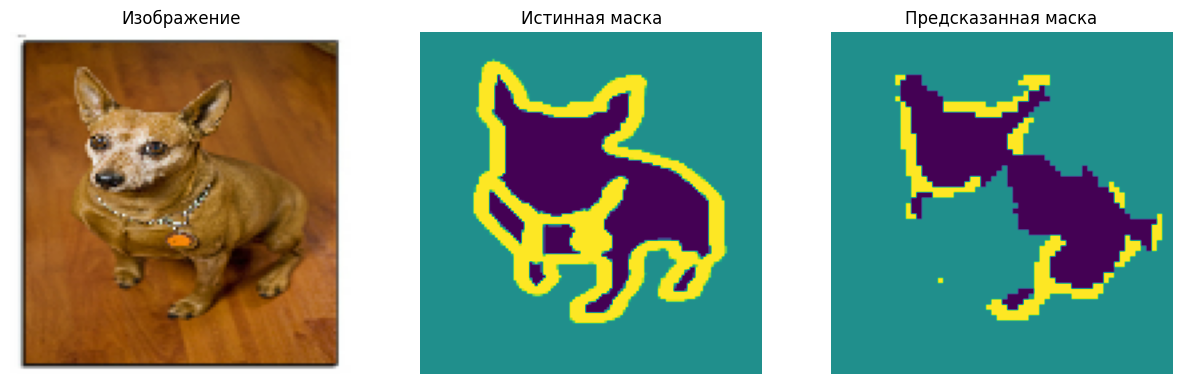

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


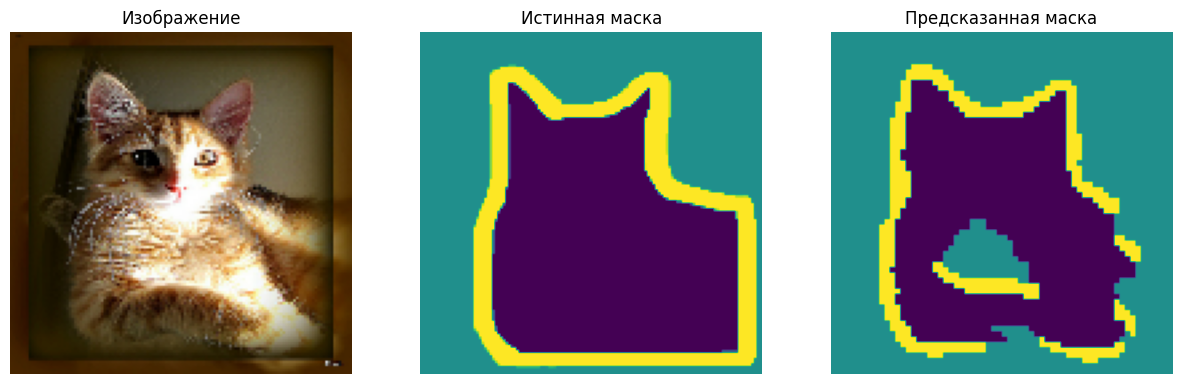

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


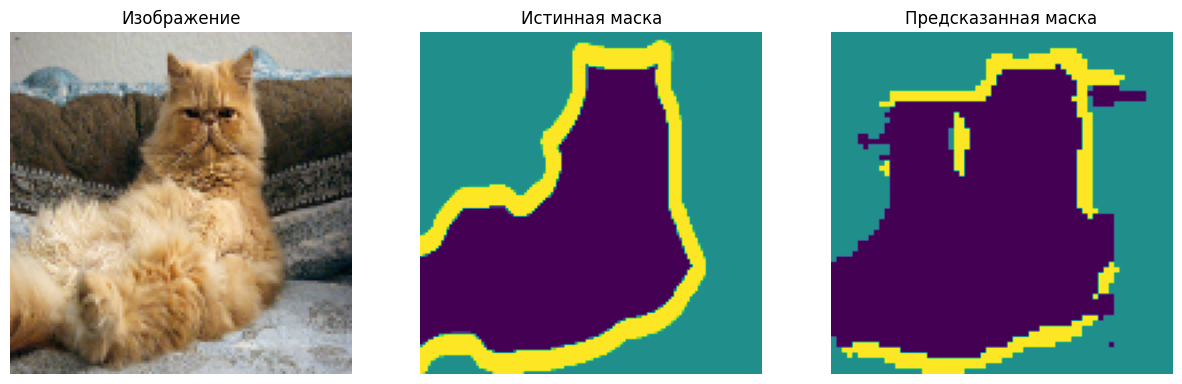

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


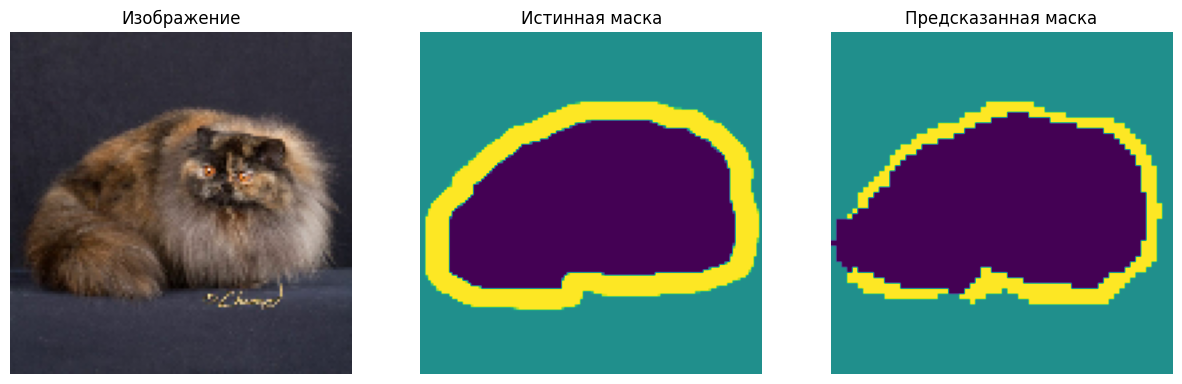

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


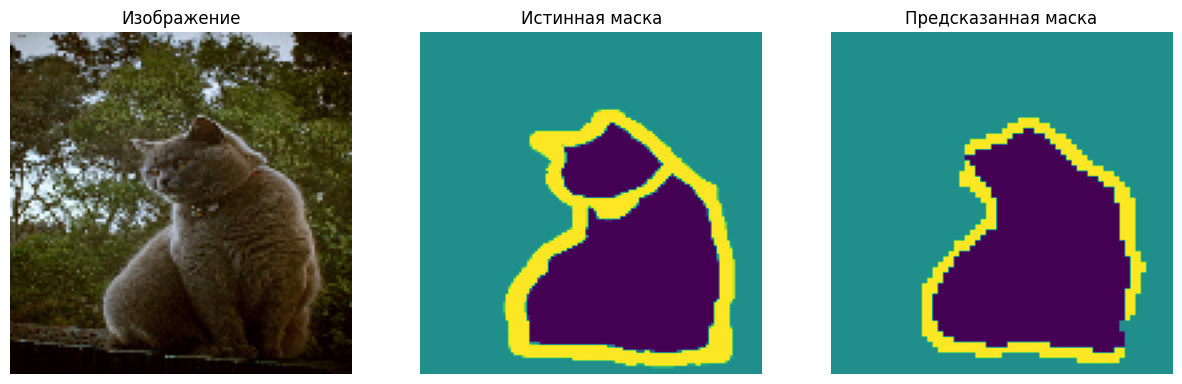

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


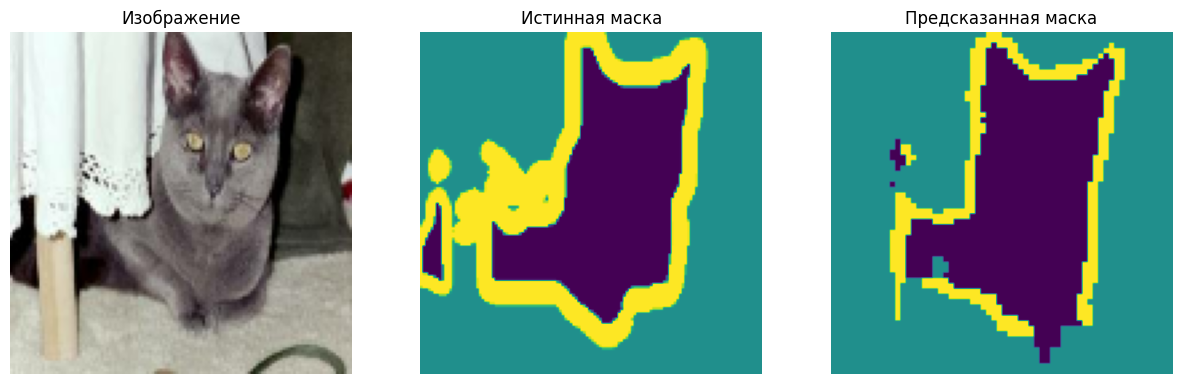

In [15]:
show_predictions(test_batches, 6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


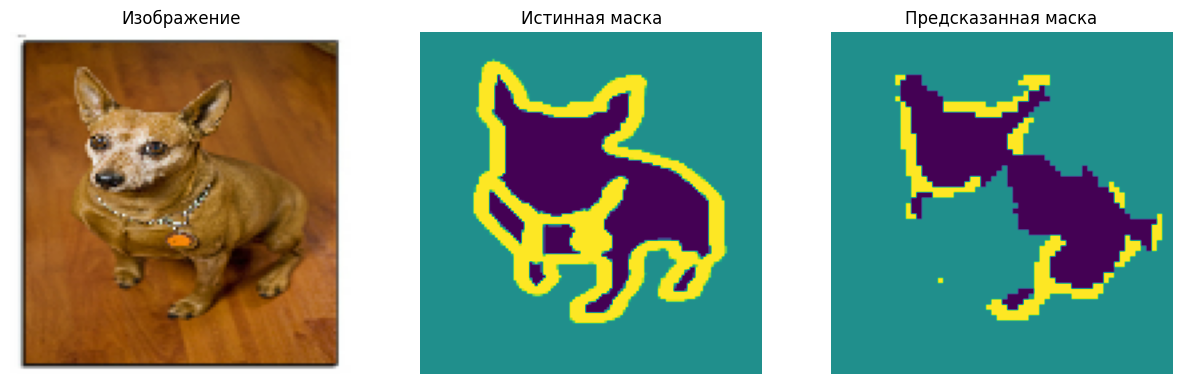

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


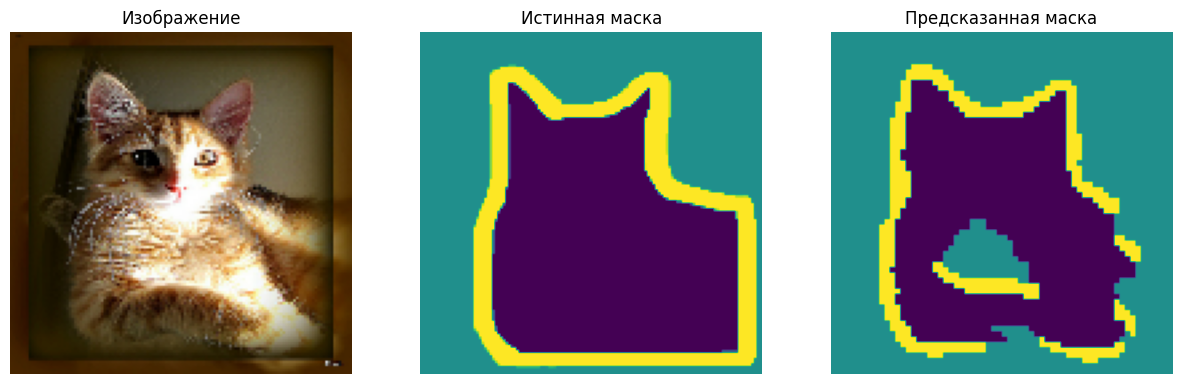

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


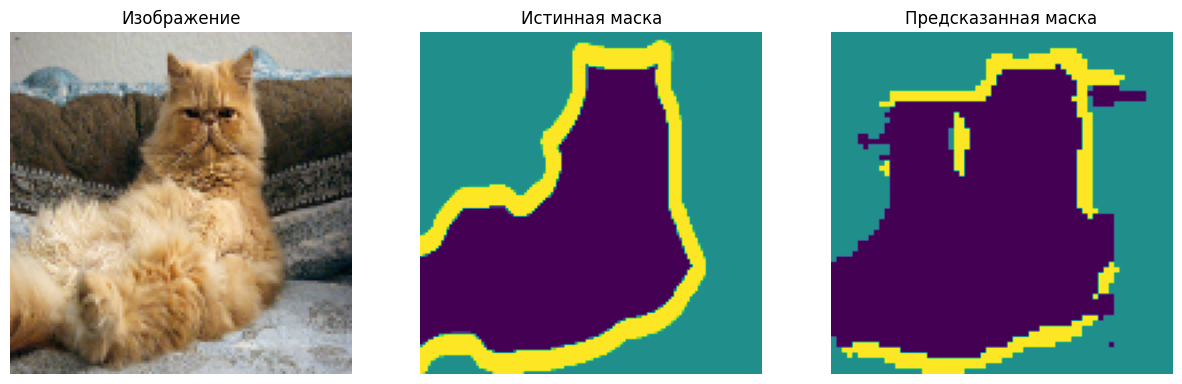

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


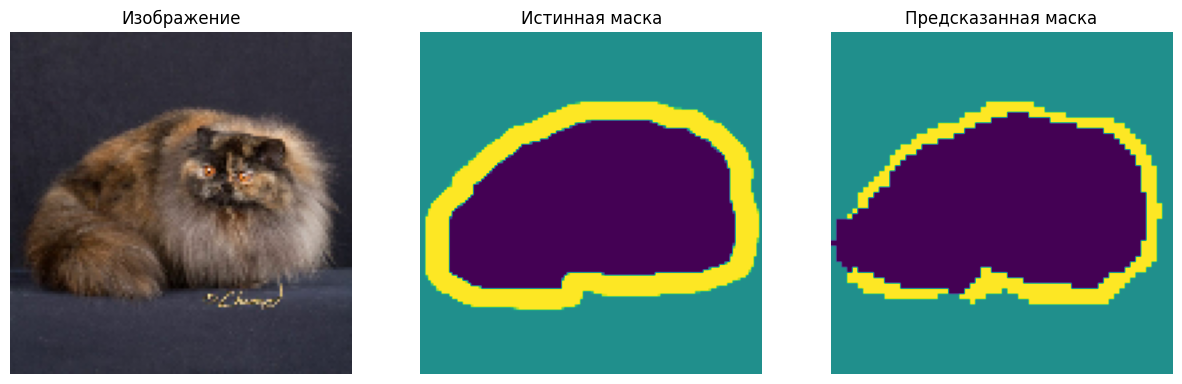

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


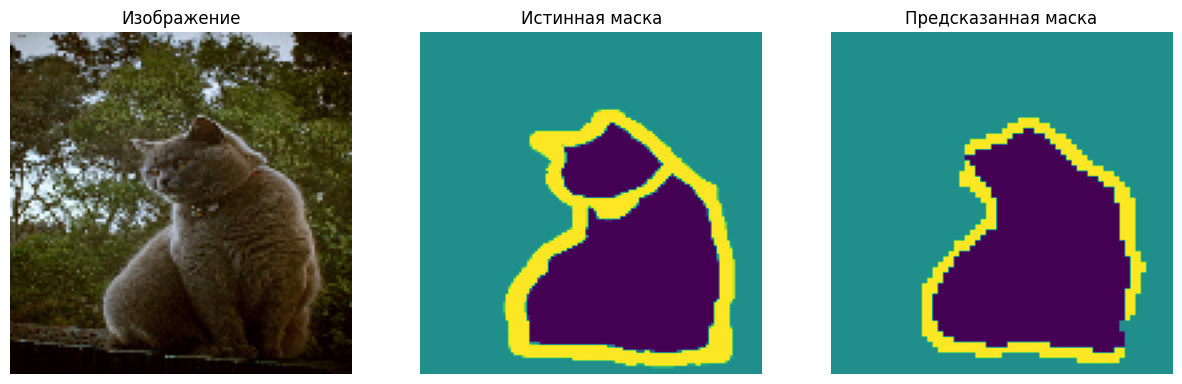

In [16]:
show_predictions(test_batches, num=5)  


### Сохранение модели

In [17]:
autoencoder_model.save('autoencoder_seg.h5')